In [320]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [252]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [253]:
def generate_rand_weighted_g(node_size=NUM_NODE, p=0.05, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [254]:
G = generate_rand_weighted_g(node_size=NUM_NODE)

print_g(G)

(0, 97, {'weight': 0.08358785062925056})
(0, 66, {'weight': 0.7634143565999103})
(0, 69, {'weight': 0.06171691714318861})
(0, 60, {'weight': 0.3316649964909534})
(0, 92, {'weight': 0.7839283177327799})
(0, 31, {'weight': 0.9632729011266646})
(1, 24, {'weight': 0.09722446931430062})
(1, 49, {'weight': 0.627910209934466})
(1, 54, {'weight': 0.8307191854070051})
(1, 30, {'weight': 0.9945325792120301})
(1, 15, {'weight': 0.6436885279401915})
(2, 0, {'weight': 0.7038574513185115})
(2, 82, {'weight': 0.7980743032580668})
(2, 35, {'weight': 0.8227885084945905})
(2, 78, {'weight': 0.2391918641470011})
(3, 33, {'weight': 0.9979970684924421})
(3, 82, {'weight': 0.045943416078371935})
(3, 52, {'weight': 0.2887652376808302})
(3, 89, {'weight': 0.9875421280835874})
(4, 96, {'weight': 0.6515003648286398})
(4, 51, {'weight': 0.14115309810617716})
(4, 66, {'weight': 0.7126841703787815})
(4, 67, {'weight': 0.508778778846733})
(4, 97, {'weight': 0.5841831670839507})
(4, 37, {'weight': 0.9375784744600245

In [256]:
print(G.number_of_nodes())
print(G.number_of_edges())

100
503


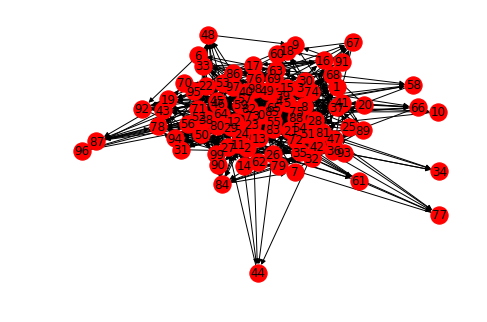

In [257]:
nx.draw(G, with_labels=True)
plt.show()

In [258]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

11

In [518]:
X, y = [], []

def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

for node in G.nodes:
    
    if G.out_degree(node) == 0:
        continue

    init_weight_vec = np.ones(max_out_degree)
    
    for idx, out_edge in enumerate(G.out_edges(node)):
        init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
#     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))
    
#     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
    label = min(out_neighbors, key=lambda d: d[1])[1]
#     print(label, init_weight_vec[np.argmin(init_weight_vec)])
    assert label == init_weight_vec[np.argmin(init_weight_vec)]
    X.append(init_weight_vec)
    y.append(label)
    
features = np.array(X)
labels = np.array(y)

In [533]:
print(X[0])
print(y[0])

[ 0.08358785  0.76341436  0.06171692  0.331665    0.78392832  0.9632729   0.
  0.          0.          0.          0.        ]
0.0617169171432


In [560]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
            
    return np.array(X_aug), np.array(y_aug)

In [561]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=200)
print(X_aug.shape)
print(y_aug.shape)

(20000, 11)
(20000, 11)


In [562]:
print(X_aug[0])
print(y_aug[0])

[ 0.08358785  0.06171692  0.331665    1.          1.          1.          0.9632729
  1.          1.          0.78392832  0.76341436]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [563]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(20000, 11)
(20000, 11)


In [564]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18000, 11)
(18000, 11)
(2000, 11)
(2000, 11)


In [571]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [572]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [573]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [574]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [570]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=50)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 50869.65 samples/sec	custom_acc=0.109091
INFO:root:Epoch[0] Batch [20]	Speed: 52821.00 samples/sec	custom_acc=0.106000
INFO:root:Epoch[0] Batch [30]	Speed: 56426.63 samples/sec	custom_acc=0.170000
INFO:root:Epoch[0] Batch [40]	Speed: 46215.17 samples/sec	custom_acc=0.174000
INFO:root:Epoch[0] Batch [50]	Speed: 53464.68 samples/sec	custom_acc=0.276000
INFO:root:Epoch[0] Batch [60]	Speed: 47841.95 samples/sec	custom_acc=0.442000
INFO:root:Epoch[0] Batch [70]	Speed: 55011.59 samples/sec	custom_acc=0.406000
INFO:root:Epoch[0] Batch [80]	Speed: 44871.34 samples/sec	custom_acc=0.494000
INFO:root:Epoch[0] Batch [90]	Speed: 53304.32 samples/sec	custom_acc=0.510000
INFO:root:Epoch[0] Batch [100]	Speed: 56375.05 samples/sec	custom_acc=0.562000
INFO:root:Epoch[0] Batch [110]	Speed: 56908.96 samples/sec	custom_acc=0.564000
INFO:root:Epoch[0] Batch [120]	Speed: 55586.09 samples/sec	custom_acc=0.588000
INFO:root:Epoch[0] Batch [130]	Speed: 53236.67 samples/sec	cu

INFO:root:Epoch[2] Batch [320]	Speed: 53879.51 samples/sec	custom_acc=0.864000
INFO:root:Epoch[2] Batch [330]	Speed: 55653.95 samples/sec	custom_acc=0.882000
INFO:root:Epoch[2] Batch [340]	Speed: 49252.04 samples/sec	custom_acc=0.894000
INFO:root:Epoch[2] Batch [350]	Speed: 52747.92 samples/sec	custom_acc=0.878000
INFO:root:Epoch[2] Train-custom_acc=0.871111
INFO:root:Epoch[2] Time cost=0.414
INFO:root:Epoch[2] Validation-custom_acc=0.890500
INFO:root:Epoch[3] Batch [10]	Speed: 53384.38 samples/sec	custom_acc=0.880000
INFO:root:Epoch[3] Batch [20]	Speed: 54775.95 samples/sec	custom_acc=0.840000
INFO:root:Epoch[3] Batch [30]	Speed: 55297.35 samples/sec	custom_acc=0.884000
INFO:root:Epoch[3] Batch [40]	Speed: 51985.62 samples/sec	custom_acc=0.868000
INFO:root:Epoch[3] Batch [50]	Speed: 52664.47 samples/sec	custom_acc=0.886000
INFO:root:Epoch[3] Batch [60]	Speed: 52598.43 samples/sec	custom_acc=0.866000
INFO:root:Epoch[3] Batch [70]	Speed: 46975.00 samples/sec	custom_acc=0.876000
INFO:roo

INFO:root:Epoch[5] Batch [270]	Speed: 49490.31 samples/sec	custom_acc=0.922000
INFO:root:Epoch[5] Batch [280]	Speed: 50095.60 samples/sec	custom_acc=0.884000
INFO:root:Epoch[5] Batch [290]	Speed: 47896.59 samples/sec	custom_acc=0.880000
INFO:root:Epoch[5] Batch [300]	Speed: 49578.06 samples/sec	custom_acc=0.908000
INFO:root:Epoch[5] Batch [310]	Speed: 50150.70 samples/sec	custom_acc=0.896000
INFO:root:Epoch[5] Batch [320]	Speed: 49058.48 samples/sec	custom_acc=0.882000
INFO:root:Epoch[5] Batch [330]	Speed: 49879.94 samples/sec	custom_acc=0.906000
INFO:root:Epoch[5] Batch [340]	Speed: 50469.33 samples/sec	custom_acc=0.906000
INFO:root:Epoch[5] Batch [350]	Speed: 48717.73 samples/sec	custom_acc=0.898000
INFO:root:Epoch[5] Train-custom_acc=0.895556
INFO:root:Epoch[5] Time cost=0.449
INFO:root:Epoch[5] Validation-custom_acc=0.913000
INFO:root:Epoch[6] Batch [10]	Speed: 51072.82 samples/sec	custom_acc=0.900000
INFO:root:Epoch[6] Batch [20]	Speed: 50963.60 samples/sec	custom_acc=0.856000
INF

INFO:root:Epoch[8] Batch [220]	Speed: 51953.43 samples/sec	custom_acc=0.890000
INFO:root:Epoch[8] Batch [230]	Speed: 50725.69 samples/sec	custom_acc=0.892000
INFO:root:Epoch[8] Batch [240]	Speed: 52164.07 samples/sec	custom_acc=0.878000
INFO:root:Epoch[8] Batch [250]	Speed: 52498.36 samples/sec	custom_acc=0.898000
INFO:root:Epoch[8] Batch [260]	Speed: 50489.98 samples/sec	custom_acc=0.888000
INFO:root:Epoch[8] Batch [270]	Speed: 51579.04 samples/sec	custom_acc=0.924000
INFO:root:Epoch[8] Batch [280]	Speed: 54530.97 samples/sec	custom_acc=0.888000
INFO:root:Epoch[8] Batch [290]	Speed: 49309.95 samples/sec	custom_acc=0.884000
INFO:root:Epoch[8] Batch [300]	Speed: 55243.45 samples/sec	custom_acc=0.922000
INFO:root:Epoch[8] Batch [310]	Speed: 54319.10 samples/sec	custom_acc=0.906000
INFO:root:Epoch[8] Batch [320]	Speed: 54376.85 samples/sec	custom_acc=0.902000
INFO:root:Epoch[8] Batch [330]	Speed: 52565.47 samples/sec	custom_acc=0.912000
INFO:root:Epoch[8] Batch [340]	Speed: 53595.85 sampl

INFO:root:Epoch[11] Batch [160]	Speed: 53441.52 samples/sec	custom_acc=0.934000
INFO:root:Epoch[11] Batch [170]	Speed: 42325.66 samples/sec	custom_acc=0.912000
INFO:root:Epoch[11] Batch [180]	Speed: 49548.78 samples/sec	custom_acc=0.908000
INFO:root:Epoch[11] Batch [190]	Speed: 53561.63 samples/sec	custom_acc=0.906000
INFO:root:Epoch[11] Batch [200]	Speed: 55389.36 samples/sec	custom_acc=0.902000
INFO:root:Epoch[11] Batch [210]	Speed: 50302.27 samples/sec	custom_acc=0.926000
INFO:root:Epoch[11] Batch [220]	Speed: 51584.11 samples/sec	custom_acc=0.892000
INFO:root:Epoch[11] Batch [230]	Speed: 50932.65 samples/sec	custom_acc=0.894000
INFO:root:Epoch[11] Batch [240]	Speed: 52887.60 samples/sec	custom_acc=0.890000
INFO:root:Epoch[11] Batch [250]	Speed: 34281.75 samples/sec	custom_acc=0.906000
INFO:root:Epoch[11] Batch [260]	Speed: 39132.54 samples/sec	custom_acc=0.888000
INFO:root:Epoch[11] Batch [270]	Speed: 47841.95 samples/sec	custom_acc=0.928000
INFO:root:Epoch[11] Batch [280]	Speed: 4

INFO:root:Epoch[14] Batch [90]	Speed: 33436.20 samples/sec	custom_acc=0.934000
INFO:root:Epoch[14] Batch [100]	Speed: 34982.27 samples/sec	custom_acc=0.932000
INFO:root:Epoch[14] Batch [110]	Speed: 32488.80 samples/sec	custom_acc=0.928000
INFO:root:Epoch[14] Batch [120]	Speed: 33071.33 samples/sec	custom_acc=0.944000
INFO:root:Epoch[14] Batch [130]	Speed: 34387.43 samples/sec	custom_acc=0.918000
INFO:root:Epoch[14] Batch [140]	Speed: 35405.73 samples/sec	custom_acc=0.910000
INFO:root:Epoch[14] Batch [150]	Speed: 36515.39 samples/sec	custom_acc=0.948000
INFO:root:Epoch[14] Batch [160]	Speed: 37282.70 samples/sec	custom_acc=0.942000
INFO:root:Epoch[14] Batch [170]	Speed: 36430.39 samples/sec	custom_acc=0.912000
INFO:root:Epoch[14] Batch [180]	Speed: 35847.53 samples/sec	custom_acc=0.910000
INFO:root:Epoch[14] Batch [190]	Speed: 36164.03 samples/sec	custom_acc=0.912000
INFO:root:Epoch[14] Batch [200]	Speed: 35194.20 samples/sec	custom_acc=0.906000
INFO:root:Epoch[14] Batch [210]	Speed: 36

INFO:root:Epoch[17] Batch [20]	Speed: 50474.19 samples/sec	custom_acc=0.894000
INFO:root:Epoch[17] Batch [30]	Speed: 49564.00 samples/sec	custom_acc=0.920000
INFO:root:Epoch[17] Batch [40]	Speed: 55698.29 samples/sec	custom_acc=0.902000
INFO:root:Epoch[17] Batch [50]	Speed: 54584.90 samples/sec	custom_acc=0.908000
INFO:root:Epoch[17] Batch [60]	Speed: 51434.82 samples/sec	custom_acc=0.922000
INFO:root:Epoch[17] Batch [70]	Speed: 52372.50 samples/sec	custom_acc=0.930000
INFO:root:Epoch[17] Batch [80]	Speed: 48614.96 samples/sec	custom_acc=0.910000
INFO:root:Epoch[17] Batch [90]	Speed: 56652.22 samples/sec	custom_acc=0.930000
INFO:root:Epoch[17] Batch [100]	Speed: 32036.66 samples/sec	custom_acc=0.934000
INFO:root:Epoch[17] Batch [110]	Speed: 48421.89 samples/sec	custom_acc=0.928000
INFO:root:Epoch[17] Batch [120]	Speed: 37059.36 samples/sec	custom_acc=0.950000
INFO:root:Epoch[17] Batch [130]	Speed: 42647.58 samples/sec	custom_acc=0.926000
INFO:root:Epoch[17] Batch [140]	Speed: 46776.97 

INFO:root:Epoch[19] Batch [320]	Speed: 52034.64 samples/sec	custom_acc=0.908000
INFO:root:Epoch[19] Batch [330]	Speed: 54674.56 samples/sec	custom_acc=0.924000
INFO:root:Epoch[19] Batch [340]	Speed: 54030.81 samples/sec	custom_acc=0.920000
INFO:root:Epoch[19] Batch [350]	Speed: 53362.65 samples/sec	custom_acc=0.922000
INFO:root:Epoch[19] Train-custom_acc=0.920000
INFO:root:Epoch[19] Time cost=0.416
INFO:root:Epoch[19] Validation-custom_acc=0.926500
INFO:root:Epoch[20] Batch [10]	Speed: 48699.63 samples/sec	custom_acc=0.912727
INFO:root:Epoch[20] Batch [20]	Speed: 48643.15 samples/sec	custom_acc=0.898000
INFO:root:Epoch[20] Batch [30]	Speed: 48751.70 samples/sec	custom_acc=0.928000
INFO:root:Epoch[20] Batch [40]	Speed: 54508.29 samples/sec	custom_acc=0.908000
INFO:root:Epoch[20] Batch [50]	Speed: 53252.89 samples/sec	custom_acc=0.912000
INFO:root:Epoch[20] Batch [60]	Speed: 50443.84 samples/sec	custom_acc=0.922000
INFO:root:Epoch[20] Batch [70]	Speed: 53407.49 samples/sec	custom_acc=0.9

INFO:root:Epoch[22] Batch [250]	Speed: 52814.34 samples/sec	custom_acc=0.928000
INFO:root:Epoch[22] Batch [260]	Speed: 51497.97 samples/sec	custom_acc=0.910000
INFO:root:Epoch[22] Batch [270]	Speed: 52642.00 samples/sec	custom_acc=0.936000
INFO:root:Epoch[22] Batch [280]	Speed: 51324.05 samples/sec	custom_acc=0.898000
INFO:root:Epoch[22] Batch [290]	Speed: 53578.05 samples/sec	custom_acc=0.908000
INFO:root:Epoch[22] Batch [300]	Speed: 51403.30 samples/sec	custom_acc=0.940000
INFO:root:Epoch[22] Batch [310]	Speed: 54030.81 samples/sec	custom_acc=0.918000
INFO:root:Epoch[22] Batch [320]	Speed: 49416.84 samples/sec	custom_acc=0.916000
INFO:root:Epoch[22] Batch [330]	Speed: 54962.57 samples/sec	custom_acc=0.924000
INFO:root:Epoch[22] Batch [340]	Speed: 50937.60 samples/sec	custom_acc=0.920000
INFO:root:Epoch[22] Batch [350]	Speed: 51572.69 samples/sec	custom_acc=0.926000
INFO:root:Epoch[22] Train-custom_acc=0.920000
INFO:root:Epoch[22] Time cost=0.429
INFO:root:Epoch[22] Validation-custom_

INFO:root:Epoch[25] Batch [180]	Speed: 55487.55 samples/sec	custom_acc=0.916000
INFO:root:Epoch[25] Batch [190]	Speed: 50020.32 samples/sec	custom_acc=0.918000
INFO:root:Epoch[25] Batch [200]	Speed: 52821.00 samples/sec	custom_acc=0.914000
INFO:root:Epoch[25] Batch [210]	Speed: 52653.90 samples/sec	custom_acc=0.936000
INFO:root:Epoch[25] Batch [220]	Speed: 53919.68 samples/sec	custom_acc=0.902000
INFO:root:Epoch[25] Batch [230]	Speed: 51535.94 samples/sec	custom_acc=0.926000
INFO:root:Epoch[25] Batch [240]	Speed: 52681.67 samples/sec	custom_acc=0.910000
INFO:root:Epoch[25] Batch [250]	Speed: 55224.54 samples/sec	custom_acc=0.932000
INFO:root:Epoch[25] Batch [260]	Speed: 48875.55 samples/sec	custom_acc=0.914000
INFO:root:Epoch[25] Batch [270]	Speed: 54448.85 samples/sec	custom_acc=0.936000
INFO:root:Epoch[25] Batch [280]	Speed: 31399.19 samples/sec	custom_acc=0.898000
INFO:root:Epoch[25] Batch [290]	Speed: 44330.69 samples/sec	custom_acc=0.910000
INFO:root:Epoch[25] Batch [300]	Speed: 5

INFO:root:Epoch[28] Batch [110]	Speed: 52686.97 samples/sec	custom_acc=0.940000
INFO:root:Epoch[28] Batch [120]	Speed: 42750.16 samples/sec	custom_acc=0.952000
INFO:root:Epoch[28] Batch [130]	Speed: 29472.18 samples/sec	custom_acc=0.938000
INFO:root:Epoch[28] Batch [140]	Speed: 36258.44 samples/sec	custom_acc=0.918000
INFO:root:Epoch[28] Batch [150]	Speed: 28229.26 samples/sec	custom_acc=0.964000
INFO:root:Epoch[28] Batch [160]	Speed: 36090.59 samples/sec	custom_acc=0.950000
INFO:root:Epoch[28] Batch [170]	Speed: 36799.89 samples/sec	custom_acc=0.932000
INFO:root:Epoch[28] Batch [180]	Speed: 36109.23 samples/sec	custom_acc=0.916000
INFO:root:Epoch[28] Batch [190]	Speed: 32446.58 samples/sec	custom_acc=0.920000
INFO:root:Epoch[28] Batch [200]	Speed: 36984.85 samples/sec	custom_acc=0.914000
INFO:root:Epoch[28] Batch [210]	Speed: 53345.00 samples/sec	custom_acc=0.936000
INFO:root:Epoch[28] Batch [220]	Speed: 48076.66 samples/sec	custom_acc=0.906000
INFO:root:Epoch[28] Batch [230]	Speed: 5

INFO:root:Epoch[31] Batch [40]	Speed: 54378.26 samples/sec	custom_acc=0.918000
INFO:root:Epoch[31] Batch [50]	Speed: 50822.80 samples/sec	custom_acc=0.922000
INFO:root:Epoch[31] Batch [60]	Speed: 54007.16 samples/sec	custom_acc=0.930000
INFO:root:Epoch[31] Batch [70]	Speed: 52730.68 samples/sec	custom_acc=0.938000
INFO:root:Epoch[31] Batch [80]	Speed: 53459.23 samples/sec	custom_acc=0.912000
INFO:root:Epoch[31] Batch [90]	Speed: 45098.10 samples/sec	custom_acc=0.932000
INFO:root:Epoch[31] Batch [100]	Speed: 35350.82 samples/sec	custom_acc=0.936000
INFO:root:Epoch[31] Batch [110]	Speed: 35673.74 samples/sec	custom_acc=0.942000
INFO:root:Epoch[31] Batch [120]	Speed: 45616.04 samples/sec	custom_acc=0.952000
INFO:root:Epoch[31] Batch [130]	Speed: 50709.74 samples/sec	custom_acc=0.940000
INFO:root:Epoch[31] Batch [140]	Speed: 53056.19 samples/sec	custom_acc=0.922000
INFO:root:Epoch[31] Batch [150]	Speed: 55406.92 samples/sec	custom_acc=0.964000
INFO:root:Epoch[31] Batch [160]	Speed: 46654.1

INFO:root:Epoch[33] Batch [340]	Speed: 52180.94 samples/sec	custom_acc=0.928000
INFO:root:Epoch[33] Batch [350]	Speed: 51056.65 samples/sec	custom_acc=0.932000
INFO:root:Epoch[33] Train-custom_acc=0.920000
INFO:root:Epoch[33] Time cost=0.421
INFO:root:Epoch[33] Validation-custom_acc=0.926000
INFO:root:Epoch[34] Batch [10]	Speed: 52938.33 samples/sec	custom_acc=0.914545
INFO:root:Epoch[34] Batch [20]	Speed: 51277.62 samples/sec	custom_acc=0.904000
INFO:root:Epoch[34] Batch [30]	Speed: 53943.26 samples/sec	custom_acc=0.946000
INFO:root:Epoch[34] Batch [40]	Speed: 54188.57 samples/sec	custom_acc=0.920000
INFO:root:Epoch[34] Batch [50]	Speed: 50438.98 samples/sec	custom_acc=0.924000
INFO:root:Epoch[34] Batch [60]	Speed: 52642.00 samples/sec	custom_acc=0.934000
INFO:root:Epoch[34] Batch [70]	Speed: 51125.11 samples/sec	custom_acc=0.940000
INFO:root:Epoch[34] Batch [80]	Speed: 49397.06 samples/sec	custom_acc=0.912000
INFO:root:Epoch[34] Batch [90]	Speed: 51125.11 samples/sec	custom_acc=0.934

INFO:root:Epoch[36] Batch [270]	Speed: 51403.30 samples/sec	custom_acc=0.944000
INFO:root:Epoch[36] Batch [280]	Speed: 50130.32 samples/sec	custom_acc=0.898000
INFO:root:Epoch[36] Batch [290]	Speed: 54525.30 samples/sec	custom_acc=0.918000
INFO:root:Epoch[36] Batch [300]	Speed: 42789.41 samples/sec	custom_acc=0.946000
INFO:root:Epoch[36] Batch [310]	Speed: 47592.24 samples/sec	custom_acc=0.922000
INFO:root:Epoch[36] Batch [320]	Speed: 53096.49 samples/sec	custom_acc=0.926000
INFO:root:Epoch[36] Batch [330]	Speed: 53281.30 samples/sec	custom_acc=0.940000
INFO:root:Epoch[36] Batch [340]	Speed: 53538.38 samples/sec	custom_acc=0.930000
INFO:root:Epoch[36] Batch [350]	Speed: 42553.25 samples/sec	custom_acc=0.932000
INFO:root:Epoch[36] Train-custom_acc=0.922222
INFO:root:Epoch[36] Time cost=0.451
INFO:root:Epoch[36] Validation-custom_acc=0.924000
INFO:root:Epoch[37] Batch [10]	Speed: 55023.14 samples/sec	custom_acc=0.918182
INFO:root:Epoch[37] Batch [20]	Speed: 52279.80 samples/sec	custom_ac

INFO:root:Epoch[39] Batch [200]	Speed: 54300.82 samples/sec	custom_acc=0.918000
INFO:root:Epoch[39] Batch [210]	Speed: 50155.50 samples/sec	custom_acc=0.946000
INFO:root:Epoch[39] Batch [220]	Speed: 54078.18 samples/sec	custom_acc=0.908000
INFO:root:Epoch[39] Batch [230]	Speed: 53718.03 samples/sec	custom_acc=0.938000
INFO:root:Epoch[39] Batch [240]	Speed: 54148.00 samples/sec	custom_acc=0.920000
INFO:root:Epoch[39] Batch [250]	Speed: 53718.03 samples/sec	custom_acc=0.940000
INFO:root:Epoch[39] Batch [260]	Speed: 50423.22 samples/sec	custom_acc=0.922000
INFO:root:Epoch[39] Batch [270]	Speed: 52322.85 samples/sec	custom_acc=0.942000
INFO:root:Epoch[39] Batch [280]	Speed: 54065.64 samples/sec	custom_acc=0.900000
INFO:root:Epoch[39] Batch [290]	Speed: 50494.85 samples/sec	custom_acc=0.918000
INFO:root:Epoch[39] Batch [300]	Speed: 53919.68 samples/sec	custom_acc=0.948000
INFO:root:Epoch[39] Batch [310]	Speed: 52148.50 samples/sec	custom_acc=0.924000
INFO:root:Epoch[39] Batch [320]	Speed: 5

INFO:root:Epoch[42] Batch [130]	Speed: 35658.57 samples/sec	custom_acc=0.942000
INFO:root:Epoch[42] Batch [140]	Speed: 50688.90 samples/sec	custom_acc=0.924000
INFO:root:Epoch[42] Batch [150]	Speed: 53192.11 samples/sec	custom_acc=0.966000
INFO:root:Epoch[42] Batch [160]	Speed: 48304.78 samples/sec	custom_acc=0.954000
INFO:root:Epoch[42] Batch [170]	Speed: 52720.08 samples/sec	custom_acc=0.940000
INFO:root:Epoch[42] Batch [180]	Speed: 54182.97 samples/sec	custom_acc=0.916000
INFO:root:Epoch[42] Batch [190]	Speed: 50388.08 samples/sec	custom_acc=0.934000
INFO:root:Epoch[42] Batch [200]	Speed: 52422.25 samples/sec	custom_acc=0.918000
INFO:root:Epoch[42] Batch [210]	Speed: 54951.05 samples/sec	custom_acc=0.950000
INFO:root:Epoch[42] Batch [220]	Speed: 54981.31 samples/sec	custom_acc=0.910000
INFO:root:Epoch[42] Batch [230]	Speed: 50906.69 samples/sec	custom_acc=0.942000
INFO:root:Epoch[42] Batch [240]	Speed: 48723.39 samples/sec	custom_acc=0.924000
INFO:root:Epoch[42] Batch [250]	Speed: 5

INFO:root:Epoch[45] Batch [60]	Speed: 55487.55 samples/sec	custom_acc=0.938000
INFO:root:Epoch[45] Batch [70]	Speed: 50648.51 samples/sec	custom_acc=0.942000
INFO:root:Epoch[45] Batch [80]	Speed: 39645.20 samples/sec	custom_acc=0.912000
INFO:root:Epoch[45] Batch [90]	Speed: 52848.95 samples/sec	custom_acc=0.940000
INFO:root:Epoch[45] Batch [100]	Speed: 51082.77 samples/sec	custom_acc=0.936000
INFO:root:Epoch[45] Batch [110]	Speed: 55772.35 samples/sec	custom_acc=0.938000
INFO:root:Epoch[45] Batch [120]	Speed: 51424.73 samples/sec	custom_acc=0.960000
INFO:root:Epoch[45] Batch [130]	Speed: 53140.89 samples/sec	custom_acc=0.944000
INFO:root:Epoch[45] Batch [140]	Speed: 56344.76 samples/sec	custom_acc=0.924000
INFO:root:Epoch[45] Batch [150]	Speed: 52132.95 samples/sec	custom_acc=0.966000
INFO:root:Epoch[45] Batch [160]	Speed: 49372.63 samples/sec	custom_acc=0.954000
INFO:root:Epoch[45] Batch [170]	Speed: 49673.18 samples/sec	custom_acc=0.946000
INFO:root:Epoch[45] Batch [180]	Speed: 55840

INFO:root:Epoch[47] Train-custom_acc=0.917778
INFO:root:Epoch[47] Time cost=0.411
INFO:root:Epoch[47] Validation-custom_acc=0.925000
INFO:root:Epoch[48] Batch [10]	Speed: 48980.57 samples/sec	custom_acc=0.921818
INFO:root:Epoch[48] Batch [20]	Speed: 53722.16 samples/sec	custom_acc=0.914000
INFO:root:Epoch[48] Batch [30]	Speed: 56186.26 samples/sec	custom_acc=0.950000
INFO:root:Epoch[48] Batch [40]	Speed: 52121.28 samples/sec	custom_acc=0.928000
INFO:root:Epoch[48] Batch [50]	Speed: 23928.07 samples/sec	custom_acc=0.936000
INFO:root:Epoch[48] Batch [60]	Speed: 54212.39 samples/sec	custom_acc=0.936000
INFO:root:Epoch[48] Batch [70]	Speed: 52477.34 samples/sec	custom_acc=0.944000
INFO:root:Epoch[48] Batch [80]	Speed: 52203.02 samples/sec	custom_acc=0.912000
INFO:root:Epoch[48] Batch [90]	Speed: 53028.02 samples/sec	custom_acc=0.944000
INFO:root:Epoch[48] Batch [100]	Speed: 50480.26 samples/sec	custom_acc=0.938000
INFO:root:Epoch[48] Batch [110]	Speed: 53689.15 samples/sec	custom_acc=0.938

In [575]:
pred = np.argmax(model.Gpredict(val_iter).asnumpy(), axis=1)
accuracy_score(np.argmax(y_test, axis=1)[:], pred[:])

AttributeError: 'Module' object has no attribute 'Gpredict'